# 시뮬레이션 방법론 과제 1 v2

20249433 최재필

In [87]:
import QuantLib as ql

import numpy as np
import pandas as pd
import scipy.stats as sst

import matplotlib.pyplot as plt


- A. 
    - Up vs Down
    - Out vs In
    - Call vs Put (총 2 * 2 * 2 = 8가지)
- B. 
    - 기초자산은 1개
    - 옵션 평가일의 기초자산 가격 S
    - GBM 프로세스 따름 
- C. 
    - 옵션 만기 T (year)
    - 만기까지 knock 여부 관측시점은 m번 ($ \Delta t = T / m $)
- D.
    - 옵션 베리어 B
    - 행사가격 K
    - 무위험 금리 (연속금리) r
    - 변동성 $ \sigma $
    - 배당 = 0
- E. 
    - replication 회수 n번

In [88]:
# Market Info
S = 100
r = 0.03
vol = 0.2

# Product Spec.
T = 1 # year
K = 100
B = 120

rebate = 0 # not needed

q = 0 # dividend yield, not needed
r = r - q

barrier_type = 'upout'
option_type = 'call'

## 1. 배리어옵션의 해석적 가격

- quantlib 사용

In [89]:
# Validate input

def check_option_types(barrier_type, option_type):

    barrier_type = barrier_type.lower()
    option_type = option_type.lower()

    assert barrier_type in ['upout', 'downout', 'upin', 'downin']
    assert option_type in ['call', 'put']

    return barrier_type, option_type

In [90]:
# Quantlib을 활용한 analytical solution (mcs와 비교용)

def barrier_option_QL(
        S, r, vol, T, K, B, rebate=0,
        barrier_type='upout',
        option_type='call'
        ):
    
    barrier_type, option_type = check_option_types(barrier_type, option_type)

    # Requires Python >= 3.10 for match-case syntax
    match barrier_type:
        case 'upout':
            barrier_type = ql.Barrier.UpOut
        case 'downout':
            barrier_type = ql.Barrier.DownOut
        case 'upin':
            barrier_type = ql.Barrier.UpIn
        case 'downin':
            barrier_type = ql.Barrier.DownIn
    
    match option_type:
        case 'call':
            option_type = ql.Option.Call
        case 'put':
            option_type = ql.Option.Put
    
    today = ql.Date.todaysDate()
    maturity = today + ql.Period(int(T*365), ql.Days)

    # barrier option
    payoff = ql.PlainVanillaPayoff(option_type, K)
    eu_exercise = ql.EuropeanExercise(maturity)
    barrier_option = ql.BarrierOption(barrier_type, B, rebate, payoff, eu_exercise)

    # market
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    flat_rate_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), vol, ql.Actual365Fixed()))
    bsm_process = ql.BlackScholesProcess(spot_handle, flat_rate_ts, flat_vol_ts)
    analytic_engine = ql.AnalyticBarrierEngine(bsm_process)

    # pricing
    barrier_option.setPricingEngine(analytic_engine)

    return barrier_option.NPV()

In [91]:
ql_price = barrier_option_QL(S, r, vol, T, K, B, rebate, barrier_type, option_type)
ql_price

1.155369999815115

## 2. MCS로 구한 가격

In [92]:
def barrier_option_MCS(
        S, r, vol, T, K, B, rebate=0,
        m=1000, n=1000,
        barrier_type='upout',
        option_type='call',
        return_disc_payoffs=False,
        ): # seed는 있으면 안된다. (seed를 고정시키면, 같은 난수가 발생한다.)

    # Requires Python >= 3.10 for match-case syntax
    barrier_type, option_type = check_option_types(barrier_type, option_type)

    ## Generate price paths

    dt = T / m
    Z = np.random.randn(n, m) # n개의 path, m개의 time step
    drift_term = (r - 0.5*vol**2) * dt # constant
    diffusion_term = vol * np.sqrt(dt) * Z # n x m matrix

    log_return = drift_term + diffusion_term
    cum_log_return = np.cumsum(log_return, axis=1)

    S_t = S * np.exp(cum_log_return)

    ## Calculate payoff

    is_call = 1 if option_type == 'call' else 0
    is_up = 1 if 'up' in barrier_type else 0
    is_in = 1 if 'in' in barrier_type else 0

    if is_up:
        barrier_breached = np.any(S_t >= B, axis=1) # ? >를 쓰는게 맞나 아니면 >=를 쓰는게 맞나?
    else:
        barrier_breached = np.any(S_t < B, axis=1) # ? 여긴 안겹치도록 해줘야 하나?

    if is_in: # Knock in
        payoffs = np.where(
            barrier_breached,
            np.maximum( is_call * (S_t[:, -1] - K), 0 ), # Max(S - K, 0) 또는 Max(K - S, 0)
            rebate,
        )
    
    else: # Knock out
        payoffs = np.where(
            barrier_breached,
            rebate,
            np.maximum( is_call * (S_t[:, -1] - K), 0 ),
        )
    
    discounted_payoffs = np.exp(-r*T) * payoffs

    option_price = np.mean(discounted_payoffs)

    if return_disc_payoffs:
        return option_price, discounted_payoffs
    else:
        return option_price

In [93]:
n = 1000
m = 1000

mcs_price = barrier_option_MCS(S, r, vol, T, K, B, rebate, m, n, barrier_type, option_type)
mcs_price

1.133111772512811

## 3. In-Out Parity


### In-Out Parity란

$$ 

call_{knock-in} + call_{knock-out} = call

$$ 

배리어를 나가던 말던 up-and-out(knock-out) 또는 up-and-in(knock-in) 둘 중 하나는 activate 되므로 둘을 합친 것은 항상 vanilla call이 되어야 한다는 parity. 

즉, 0 + c = c 또는 c + 0 = 0 이기에 성립한다는 것. 

출처: [Python for Finance](https://subscription.packtpub.com/book/data/9781783284375/11/ch11lvl1sec176/barrier-in-and-out-parity)


### MCS 옵션 평가에서 활용할 수 있는 방법

둘은 parity이므로 

- 우선 계산량이 적은 vanilla call의 가치를 먼저 mcs로 구하고 
- up-and-out 또는 up-and-in 둘 중 하나를 mcs로 구하면 
- 나머지 하나는 자동으로 구할 수 있다. 
- knock-out과 knock-in의 연산 차이:
    - python의 경우 vectorized 연산을 위해 모든 path를 구해놓고 연산하기에 in/out의 연산이 동일
    - iteration을 통해 path를 generate하는 다른 언어의 경우 out이 in보다 계산하기 쉬움 
        - out의 경우 barrier touch 하는 순간 option 자체가 사라짐. 가치 0. 그 다음부턴 계산할 필요가 없음. 
        - in의 경우 barrier touch하는 순간 option이 activate됨. 나머지 path를 다 그려야 final payoff를 구할 수 있음. 
    - 때문에 in-out parity를 사용할 때 먼저 knock-out 옵션의 가격을 구하고 vanilla option에서 빼서 knock-in 옵션의 가격을 구하는 것이 좋음. 

## 4. Bias-Variance Trade-off

- 변수 정의
    - N: number of simulations
    - n: number of paths
    - m: number of time steps
- bias
    - "quantlib으로 계산한 analytic 솔루션의 값" 과 "몬테카를로 시뮬레이션으로 구한 N개의 결과의 평균" 의 차이를 구한 것. 
    - 이를 제곱해야 bias^2가 나온다. 
- variance
    - N번 simulation한 결과값들 사이의 분산
    - 하지만, CLT를 이용하면 단 한 번의 simulation으로 variance를 구할 수 있다. 
        - simulation 자체가 n번의 평균이기에 표본평균 $ \bar{X} $ 이고
        - N번 simulation 한 것들의 분산은 표본평균의 분산, 즉 $ \bar{X_1}, \bar{X_2}, \bar{X_3}, ... $  의 분산이다
            - 만약 CLT를 쓰지 않고 N번 $ \bar{X_i} $ 를 구해 variance를 구한다면 sample variance인 `ddof=n-1`을 써야 한다. 
            - 만약 CLT를 쓴다면 단일 simulation에서의 분산 $ \sigma^2 $ 을 구한 후 CLT에 의해 $ \bar{X} \sim \mathcal{N}( \mu, \frac{ \sigma^2 }{ n } ) $ 가 성립함을 이용하면 된다. 
- 연산 예산 (computational budget)
    - N은 30번 고정, `budget = n * m` 
    - log scale로 볼 수 있게 power of 2로 n과 m을 설정

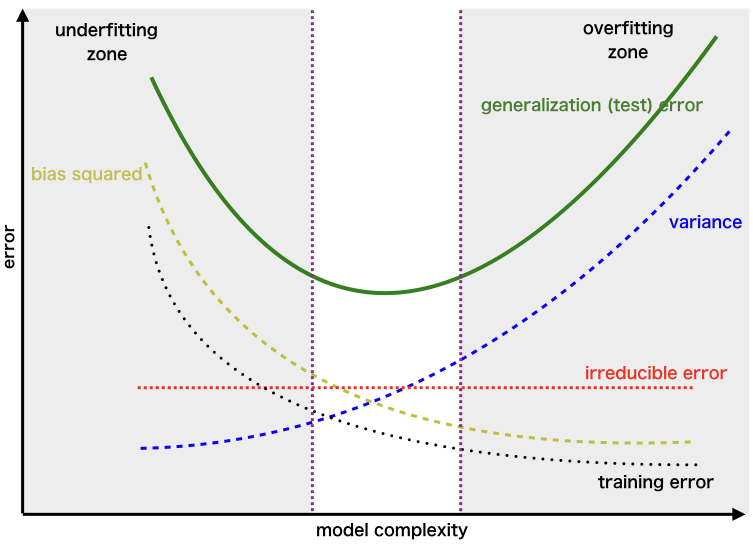

In [94]:
N = 50

start = 6
end = 20

budget = 2 ** end # = m * n. 이렇게 해야 trade-off를 볼 수 있음. 

In [95]:
n_values = 2 ** np.arange(start, end - start + 1)
m_values = budget // n_values

In [96]:
ql_price = barrier_option_QL(S, r, vol, T, K, B, rebate, barrier_type, option_type)

results = []

for n, m in zip(n_values, m_values):

    print(f'Calculating for n=2^{np.log2(n)}, m=2^{np.log2(m)}')

    bias_values = []
    mcs_values = [] # to calculate variance from N simulations
    clt_variance = 0 # variance using CLT from 1 simulation

    for i in range(N):
        mcs_price, disc_payoffs = barrier_option_MCS(S, r, vol, T, K, B, rebate, m, n, barrier_type, option_type,
                                                     return_disc_payoffs=True)
        mcs_values.append(mcs_price)

        # variance using CLT from 1 simulation
        if i == 0:
            clt_variance = np.var(disc_payoffs) / n
    
    mcs_values = np.array(mcs_values)

    # Bias
    bias2 = np.mean( mcs_values - ql_price ) ** 2
    
    # variance from N simulations
    variance_from_N = np.var(mcs_values, ddof=1)
    
    result = {
        'n': n,
        'm': m,
        'bias2': bias2,
        'variance_from_N': variance_from_N,
        'clt_variance': clt_variance,
    }

    results.append(result)
        


Calculating for n=2^6.0, m=2^14.0
Calculating for n=2^7.0, m=2^13.0
Calculating for n=2^8.0, m=2^12.0
Calculating for n=2^9.0, m=2^11.0
Calculating for n=2^10.0, m=2^10.0
Calculating for n=2^11.0, m=2^9.0
Calculating for n=2^12.0, m=2^8.0
Calculating for n=2^13.0, m=2^7.0
Calculating for n=2^14.0, m=2^6.0


In [97]:
df = pd.DataFrame(results)

In [98]:
# df['mse'] = df['bias2'] + df['variance_from_N']
df['mse'] = df['bias2'] + df['clt_variance']

In [99]:
df

,n,m,bias2,variance_from_N,clt_variance,mse
0,64,16384,0.007186,0.237693,0.154137,0.161323
1,128,8192,0.008514,0.087106,0.078537,0.087051
2,256,4096,0.001953,0.030817,0.040558,0.042511
3,512,2048,0.000210,0.022061,0.028544,0.028754
4,1024,1024,0.003610,0.011778,0.008684,0.012294
5,2048,512,0.009386,0.008138,0.005853,0.015238
6,4096,256,0.018947,0.003013,0.002715,0.021662
7,8192,128,0.045437,0.001156,0.001479,0.046915
8,16384,64,0.084729,0.001190,0.000781,0.085509


<Axes: title={'center': 'Bias-Variance Tradeoff'}, xlabel='n', ylabel='Value'>

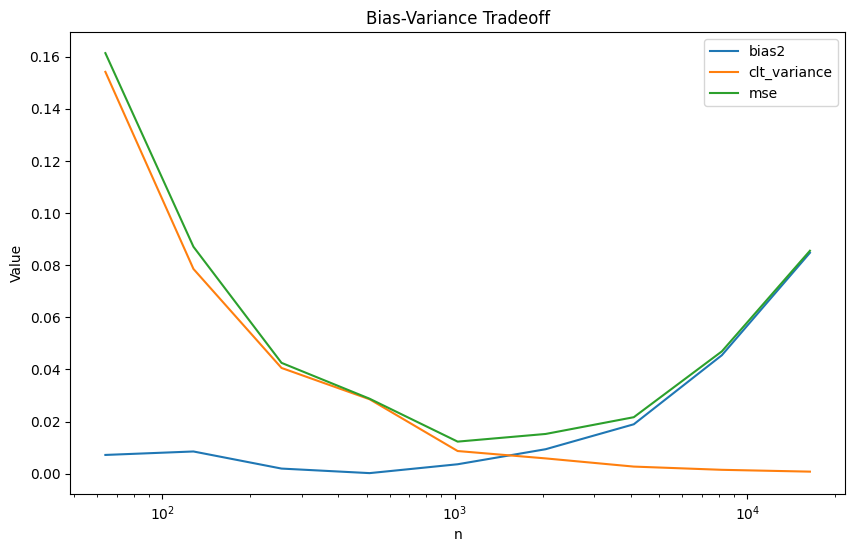

In [100]:
# df[['n', 'bias2', 'variance_from_N', 'mse']].plot(
df[['n', 'bias2', 'clt_variance', 'mse']].plot(
    x='n',
    logx=True,
    logy=False,
    title='Bias-Variance Tradeoff',
    xlabel='n',
    ylabel='Value',
    figsize=(10, 6),
)

<Axes: title={'center': 'Variance Comparison'}, xlabel='n', ylabel='Value'>

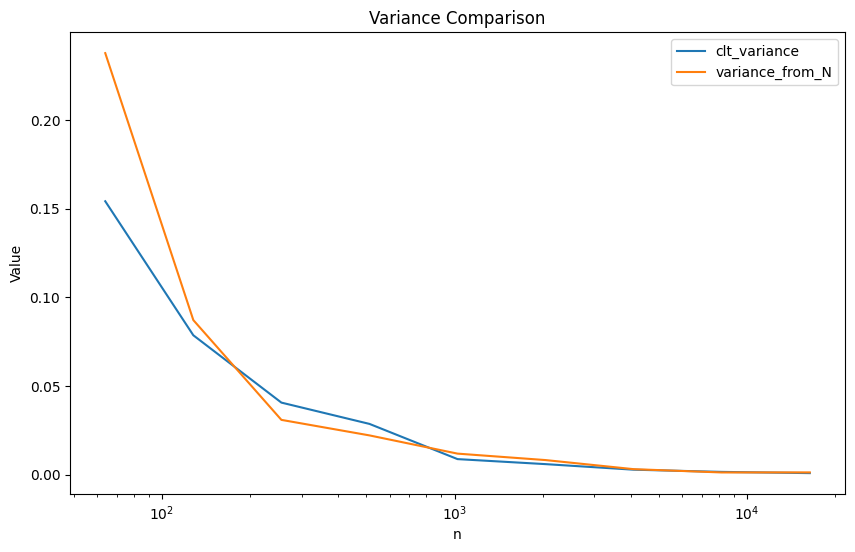

In [101]:
df[['n', 'clt_variance', 'variance_from_N']].plot(
    x='n',
    logx=True,
    logy=False,
    title='Variance Comparison',
    xlabel='n',
    ylabel='Value',
    figsize=(10, 6),
)